In [24]:
# OPTIONAL SETUP (run once if dependencies are not installed)
# import sys
# import subprocess
# subprocess.run(
#     [sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"],
#     check=True
# )

In [1]:
from pathlib import Path
from zenodo_get import download
import utils
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import contextlib

# Introduction

This notebook tests the Plane Wave Fit package in a realistic analysis. We focus on extracting the mode-1 M$_2$ internal tide near 35°W, 35.5°S in the South Atlantic using SWOT sea surface height anomaly (SSHA) measurements collected during the Cal/Val phases (102 cycles with a 0.9935-day repeat period).

## Initialization

- **Load SSHA dataset**

  The SWOT SSHA data are provided on a two-dimensional swath grid with the following dimensions:

  - latitude: (num_lines, num_pixels)  
  - longitude: (num_lines, num_pixels)  
  - time: (num_cycles, num_lines)  
  - ssha: (num_cycles, num_lines, num_pixels)

  SWOT is a swath-mapping mission. The `num_lines` dimension corresponds to the along-track direction, while `num_pixels` corresponds to the across-track direction. The time variable has dimensions `(num_cycles, num_lines)` because all across-track pixels within a given swath line are observed at the same time.

- **Prescribe wave parameters**

The SSHA field is modeled as a superposition of plane-wave components:

$$
\mathrm{SSHA}(x, y, t)
=
\sum_{m=1}^{N}
A_m
\cos\!\left(
k\,x\cos\theta_m
+
k\,y\sin\theta_m
-
\omega t
-
\phi_m
\right).
$$

Here, $A_m$, $\theta_m$, and $\phi_m$ are the amplitude, propagation direction, and phase of the $m$-th component; $k$ (rad km$^{-1}$) is the horizontal wavenumber magnitude; and $\omega$ (rad day$^{-1}$) is the M$_2$ angular frequency. The variables $x$ and $y$ denote eastward and northward Cartesian coordinates, and $t$ is time.

The horizontal wavenumber $k$ may be prescribed directly by the user. Otherwise, $k$ is obtained from a pre-calculated NetCDF file derived from climatological ocean stratification from the World Ocean Atlas 2023 (WOA23), archived at https://doi.org/10.5281/zenodo.18423546.




#### Load the example SWOT SSHA dataset

An example SWOT sea surface height anomaly (SSHA) dataset is provided in the `data/` folder of this repository. The file contains SSHA measurements extracted near **35°W, 35.5°S** during the SWOT Cal/Val phases and is used to demonstrate the plane-wave fitting workflow.

*Note:* If you cloned/downloaded the entire repository, the data file is already available. If the file is missing, download it from the [repository's data folder](https://github.com/youranli001/plane-wave-fit/tree/main/data).

In [2]:
data_dir = Path("../data")
ssha_fn = "SWOT_CalVal_SSHA_35W_35p5S.nc"
filepath = data_dir / ssha_fn

# Try to load from repo
if filepath.exists():
    ds = xr.open_dataset(filepath)
else:
    # Provide helpful error message
    github_url = f"https://github.com/youranli001/plane-wave-fit/raw/main/data/{ssha_fn}"
    raise FileNotFoundError(
        f"{ssha_fn} not found in {data_dir}.\n\n"
        f"Please download the data file:\n"
        f"1. Download from: {github_url}\n"
        f"2. Save to: {filepath.absolute()}\n\n"
        f"Or clone/download the entire repository to get all data files."
    )

C:\Users\Owner\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


#### plot ssha

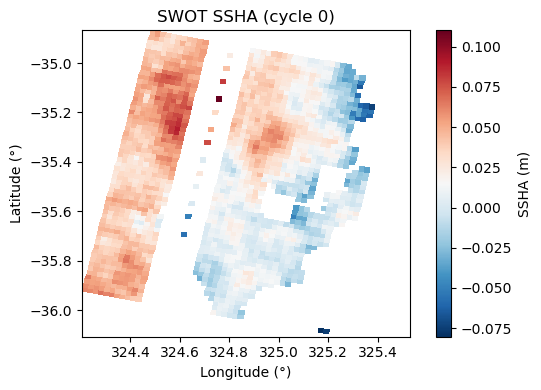

In [3]:
# select one cycle (e.g., the first)
cycle = 0

fig, ax = plt.subplots(figsize=(6, 4))

pcm = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.ssha.isel(num_cycles=cycle),
    shading="auto",
    cmap="RdBu_r"
)

cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("SSHA (m)")

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title(f"SWOT SSHA (cycle {cycle})")

ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


#### calculate x and y from lon and lat
Longitude and latitude are converted to local Cartesian coordinates $(x, y)$, defined as the zonal and meridional distances (km) from a reference location at $(35^\circ\mathrm{W}, 35.5^\circ\mathrm{S})$. These coordinates are used for the plane wave fit.


In [6]:
lon_example, lat_example = -35, -35.5
distX, distY = utils.lonlat2xy(ds.longitude.values, ds.latitude.values, lon_example, lat_example) 

#### Load prescribed wave parameters: wave frequency and wavenumber

Here I use M2 wave frequency, and the mode-1 M2 wavenumber at the example site. 

If you would like to access the precomputed internal-tide parameters used here (and explore additional fields such as phase speed, group speed, and vertical mode structure), see the companion notebook **`<lookup_mode1_M2_wave_parameters.ipynb>`**, which demonstrates how to load the precomputed lookup table and extract the mode-1 M$_2$ wavenumber and related fields at any longitude and latitude.

In [7]:
# M2 frequency [rad/day]
# 12.42 h
omega = 2 * np.pi / (12.42 * 3600) * 24 * 3600

# wavenumber [rad/km]
# k = 0.04124732611475162
k = 0.0413064207

In [8]:
# make x y t data all into dimensions (num_cycles, num_lines, num_pixels)
ssha = ds['ssha'].values  # SSHA (m)
X_3D      = np.repeat(distX[np.newaxis, :, :], ds.sizes['num_cycles'], axis=0)   # x [km]
Y_3D      = np.repeat(distY[np.newaxis, :, :], ds.sizes['num_cycles'], axis=0)   # y [km]
T_3D_dt64 = np.repeat(ds['time'].values[:, :, np.newaxis], ds.sizes['num_pixels'], axis=2)   # datetime64
T_3D      = utils.datetime64_to_matlab_datenum(T_3D_dt64)                           # decimal days since 0000-01-01


C:\Users\Owner\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


#### Apply the Plane Wave Fit code

For each fitting window, the amplitude and phase of a plane wave are determined for each compass direction (angular increment 1$^{\circ}$) using least-squares fitting. When the fitted amplitudes are plotted as a function of direction in polar coordinates, an internal tidal wave appears to be a lobe. The largest lobe gives the amplitude and direction of the strongest internal tidal wave. The signal of this wave is then predicted and removed from the initial SSHA measurements. This procedure can be repeated to extract an arbitrary number of M$_2$ internal tidal waves. Here, the analysis is conducted to the first three waves.

**Inputs**
- `data_3D` (`ssha`): SSHA values on a 3-D window with shape `(time, along_track, across_track)` (NaNs allowed).
- `k` (rad km$^{-1}$): prescribed horizontal wavenumber magnitude.
- `omega` (rad day$^{-1}$): prescribed angular frequency.
- `X_3D`, `Y_3D` (km): local Cartesian coordinates for each SSHA sample in the window (same shape as `data_3D`).
- `T_3D` (day): observation time for each sample (same shape as `data_3D`).

**Outputs**
- `max_amplitude`: amplitude (m).
- `max_angle`: propagation direction (degrees).
- `phase`: phase (rad)
- `best_predicted_wave`: reconstructed mode-1 M2 SSH time series at the example site.
- `residual_variances`: remaining (unexplained) variance after fitting a plane wave for each propagation direction.
- `amplitudes`: fitted amplitude for compass direction.
- `phases`: fitted phase for each compass direction.
- `uncertainty_estimates`: dictionary containing regression uncertainty diagnostics.
  - `dof`: degrees of freedom used in the least-squares fit.
  - `t_critical`: critical value of the Student’s *t* distribution for a 95% confidence interval.
  - `beta`: fitted regression coefficients `[β_cos, β_sin]` for the cosine and sine components of the plane-wave model.
  - `standard_errors_beta`: standard errors of the regression coefficients, derived from the coefficient covariance matrix.
  - `standard_error_amplitude`: approximate standard error of the fitted wave amplitude, propagated from the coefficient uncertainties.
  - `standard_error_phase`: approximate standard error of the fitted wave phase, propagated from the coefficient uncertainties.
  - `cov_matrix_beta`: covariance matrix of the fitted regression coefficients.



In [9]:

max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, phases1, uncertainty_estimates1 = utils.fit_wave(ssha, k, omega, X_3D, Y_3D, T_3D)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, phases2, uncertainty_estimates2 = utils.fit_wave(ssha - best_predicted_wave1, k, omega, X_3D, Y_3D, T_3D)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, phases3, uncertainty_estimates3 = utils.fit_wave(ssha - best_predicted_wave1 - best_predicted_wave2, k, omega, X_3D, Y_3D, T_3D)


The polar plots show the fitted plane-wave amplitude as a function of propagation direction for three independent realizations. In each case, a clear dominant lobe is present, indicating a well-defined propagation direction for the mode-1 M$_2$ internal tide near 35°W, 35.5°S. The arrow marks the propagation direction of the fitted plane wave (i.e., the direction of the horizontal wavevector that maximizes the fitted amplitude) and the corresponding peak amplitude.


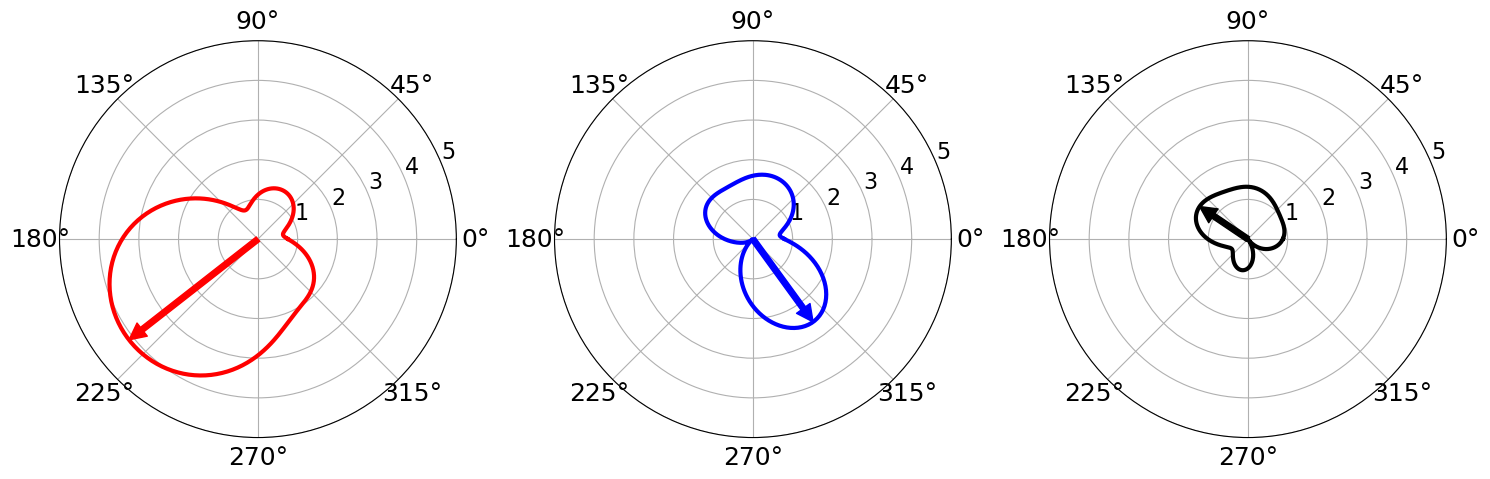

In [10]:
angles_degrees = np.arange(1, 361)
angles_radians = np.radians(angles_degrees)

# from m to mm
amplitudes = [1e3 * amplitudes1, 1e3 * amplitudes2, 1e3 * amplitudes3] # from (m) to (mm)
colors = ['red', 'blue', 'black']

# Arrow directions (degrees)
max_angles_deg = [max_angle1, max_angle2, max_angle3]

fig, axs = plt.subplots(1, 3,subplot_kw={'polar': True},figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    amp = amplitudes[i]
    color = colors[i]

    ax.plot(angles_radians, amp, color=color, linewidth=3)

    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    ax.set_rlim(0, 5)

    # ---- LOCAL font size control ----
    ax.tick_params(axis='x', labelsize=18)   # angular labels
    ax.tick_params(axis='y', labelsize=16)   # radial labels

    # optional: fewer, larger radial ticks
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels([1, 2, 3, 4, 5], fontsize=16)

    # Arrow direction
    arrow_angle_deg = max_angles_deg[i] % 360
    arrow_angle_rad = np.deg2rad(arrow_angle_deg)

    idx = int(round(arrow_angle_deg)) % 360
    arrow_length = amp[idx]

    ax.annotate(
        '',
        xy=(arrow_angle_rad, arrow_length),
        xytext=(0, 0),
        arrowprops=dict(
            facecolor=color,
            edgecolor=color,
            width=4,
            headwidth=12
        )
    )

plt.tight_layout()
plt.show()


 The table lists the amplitude, propagation direction, and phase for the first three extracted plane-wave components. Phases are wrapped to [0°, 360°]. 


In [11]:
# Convert phases from radians to degrees and wrap to [0,360]
phase_deg1 = ((np.degrees(phase1) + 180) % 360) - 180
phase_deg2 = ((np.degrees(phase2) + 180) % 360) - 180
phase_deg3 = ((np.degrees(phase3) + 180) % 360) - 180

tbl = {
    "Parameter": ["Max Amplitude (mm)", "Max Angle (deg)", "Phase (deg)"],
    "Wave 1": [1e3 * max_amplitude1, max_angle1, phase_deg1],
    "Wave 2": [1e3 * max_amplitude2, max_angle2, phase_deg2],
    "Wave 3": [1e3 * max_amplitude3, max_angle3, phase_deg3],
}
df = pd.DataFrame(tbl).set_index("Parameter")
display(df.round(2))

,Wave 1,Wave 2,Wave 3
Parameter,,,
Max Amplitude (mm),4.12,2.58,1.47
Max Angle (deg),218.00,306.00,146.00
Phase (deg),11.45,-133.18,7.96


print uncertainty estimates

In [12]:
pp = pprint.PrettyPrinter(indent=2, width=80)

print("Uncertainty estimate of wave 1: ")
pp.pprint(uncertainty_estimates1)
print("\n")

print("Uncertainty estimate of wave 2: ")
pp.pprint(uncertainty_estimates2)
print("\n")

print("Uncertainty estimate of wave 3: ")
pp.pprint(uncertainty_estimates3)
print("\n")

Uncertainty estimate of wave 1: 
{ 'beta': array([0.00404171, 0.00081177]),
  'cov_matrix_beta': array([[ 5.38831997e-09, -1.10502601e-11],
       [-1.10502601e-11,  5.37505836e-09]]),
  'dof': 202040,
  'standard_error_amplitude': 7.340167400340545e-05,
  'standard_error_phase': 0.017785247633212355,
  'standard_errors_beta': array([7.34051767e-05, 7.33147895e-05]),
  't_critical': 1.9599757262011126}


Uncertainty estimate of wave 2: 
{ 'beta': array([-0.00176816, -0.00187868]),
  'cov_matrix_beta': array([[ 5.35300839e-09, -7.10871707e-12],
       [-7.10871707e-12,  5.34435701e-09]]),
  'dof': 202040,
  'standard_error_amplitude': 7.313289790252983e-05,
  'standard_error_phase': 0.02834864060789907,
  'standard_errors_beta': array([7.31642562e-05, 7.31051093e-05]),
  't_critical': 1.9599757262011126}


Uncertainty estimate of wave 3: 
{ 'beta': array([0.00145113, 0.00020129]),
  'cov_matrix_beta': array([[5.35971292e-09, 4.70129553e-12],
       [4.70129553e-12, 5.31664994e-09]]),
  

To calculate maximum vertical displacement, depth-integrated KE, PE, and E, and depth-integrated energy flux, see the example in 03_access_internal_tide_parameters.ipynb